In [1]:
"""
This notebook generates the figures that summarize classification/decoding performance. 
"""

'\nThis notebook generates the figures that summarize classification/decoding performance. \n'

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler
# %pdb

import os
import sys
os.environ['MKL_THREADING_LAYER'] = 'GNU'

from matplotlib import pyplot as plt
import numpy as np
import scipy.stats

# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA
from scipy.ndimage.filters import gaussian_filter1d

import pickle 
import keras
import time
import copy

from cosmos.traces.decoding_utils import *
from cosmos.traces.decoding.metrics import get_R2, get_rho
from cosmos.traces.decoding.decoders import DenseNNDecoder, LSTMDecoder
from cosmos.traces.decoding.decoders import GRUDecoder, SVRDecoder, XGBoostDecoder, SimpleRNNDecoder

import cosmos.traces.trace_analysis_utils as utils
import cosmos.traces.clustering_utils as cu
from cosmos.behavior.bpod_dataset import BpodDataset
from cosmos.traces.cell_plotter import CellPlotter
from cosmos.traces.cosmos_traces import CosmosTraces
import cosmos.params.trace_analyze_params as params

import matplotlib
matplotlib.rcParams.update({'xtick.major.pad': '2'})
matplotlib.rcParams.update({'ytick.major.pad': '2'})
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams['pdf.fonttype'] = 42 # truetype
matplotlib.rcParams['ps.fonttype'] = 42

Using TensorFlow backend.


In [3]:
%pdb

Automatic pdb calling has been turned ON


In [4]:
# Select workstation for loading.
workstation = 'analysis2' #'analysis2'

if workstation == 'analysis2':
    base_dir = '/home/izkula/Dropbox/'
elif workstation == 'cosmosdata':
    base_dir = '/home/user/Dropbox'
    
data_dir = base_dir + '/cosmos_data/'
general_plots_save_dir = base_dir + '/cosmos/trace_analysis/'
fig_save_dir = base_dir + '/cosmos/fig_plots/fig6/nonbinarized_1timepoint'
bpod_dir = base_dir + '/cosmos_data/behavior/'
# classification_dir = base_dir + '/cosmos_data/lick_classification_results/'

if not os.path.isdir(fig_save_dir):
    os.makedirs(fig_save_dir)

                 Anova
         F Value  Num DF  Den DF Pr > F
---------------------------------------
nsources 240.8364 4.0000 12.0000 0.0000

 p0 0.00194**, p1 0.00194**,  p2 0.00194**, p3 0.00718** vs1000=0

Saved to /home/izkula/Dropbox//cosmos/fig_plots/fig6/nonbinarized_1timepointmax_accuracy_vs_nneurons_PCA
 p0 0.00149**, p1 0.00266**,  p2 0.00566**, p3 0.00117**, p4 0.00266**

Saved to /home/izkula/Dropbox//cosmos/fig_plots/fig6/nonbinarized_1timepointmax_accuracy_vs_region
 p0 0.0198*, p1 0.0198*,  p2 0.0804ns, p3 0.151ns, p4 0.0548ns

Saved to /home/izkula/Dropbox//cosmos/fig_plots/fig6/nonbinarized_1timepointunique_region_contribution


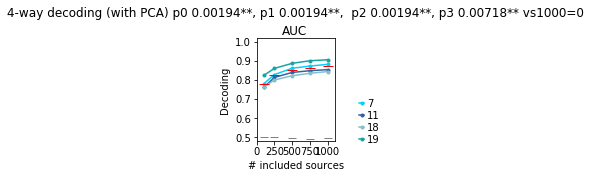

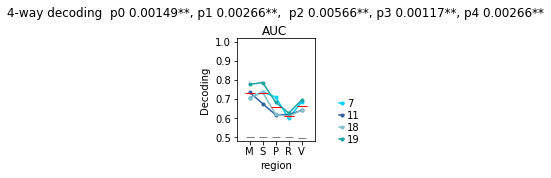

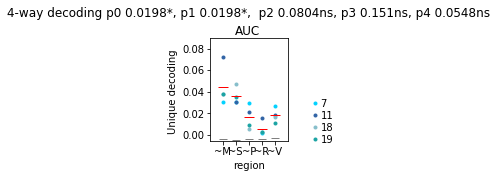

In [11]:
# Compare the decoding performance of a number of different subsets of sources.

concluded_expts = {
    ### Below is using the refactored decoding. Used in cellFig5_1.pdf.
    ### See expt_group_id in du.select_experiment_group for explanations of 'info'.

    ### Initial runs after factoring the code. I think these had a bug in them though. 
    107: {'id': 11, 'expt_nums': np.arange(536, 556),'expt_type': 'nneurons', 'info':8}, # 75 pcs
    108: {'id': 11, 'expt_nums': np.arange(556, 580),'expt_type': 'neuron_set', 'info':9}, # 75 pcs
    109: {'id': 11, 'expt_nums': np.arange(580, 600),'expt_type': 'neuron_set', 'info':4},  # 75 pcs
    
    110: {'id': 18, 'expt_nums': np.arange(259, 279),'expt_type': 'nneurons', 'info':8}, # 75 pcs
    111: {'id': 18, 'expt_nums': np.arange(279, 303),'expt_type': 'neuron_set', 'info':9}, # 75 pcs
    112: {'id': 18, 'expt_nums': np.arange(303, 323),'expt_type': 'neuron_set', 'info':4}, # 75 pcs
    
    113: {'id': 19, 'expt_nums': np.arange(596, 616),'expt_type': 'nneurons', 'info':8},  # 75 pcs
    114: {'id': 19, 'expt_nums': np.arange(616, 640),'expt_type': 'neuron_set', 'info':9},  # 75 pcs
    115: {'id': 19, 'expt_nums': np.arange(640, 660),'expt_type': 'neuron_set', 'info':4},  # 75 pcs
    
    116: {'id': 7, 'expt_nums': np.arange(2071, 2091),'expt_type': 'nneurons', 'info':8},  # 75 pcs
    117: {'id': 7, 'expt_nums': np.arange(2091, 2115),'expt_type': 'neuron_set', 'info':9},  # 75 pcs
    118: {'id': 7, 'expt_nums': np.arange(2115, 2135),'expt_type': 'neuron_set', 'info':4},  # 75 pcs
    
    119: {'id': 18, 'expt_nums': np.arange(323, 327),'expt_type': 'neuron_set', 'info':10}, ### All sources
    120: {'id': 11, 'expt_nums': np.arange(600, 604),'expt_type': 'neuron_set', 'info':10}, ### All sources
    121: {'id': 19, 'expt_nums': np.arange(578, 582),'expt_type': 'neuron_set', 'info':10}, ### All sources
    122: {'id': 7, 'expt_nums': np.arange(2067, 2071),'expt_type': 'neuron_set', 'info':10}, ### All sources
    
    
    ### After rerunning with the fixed bug. 4way 75 pcs. 3-frames preceding the timepoint. 
    201: {'id': 7, 'expt_nums': np.arange(2154, 2174),'expt_type': 'nneurons', 'info':8}, # 4way, 75 pcs
    202: {'id': 11, 'expt_nums': np.arange(612, 632),'expt_type': 'nneurons', 'info':8}, # 4way, 75 pcs
    203: {'id': 18, 'expt_nums': np.arange(335, 355),'expt_type': 'nneurons', 'info':8}, # 4way, 75 pcs
    204: {'id': 19, 'expt_nums': np.arange(672, 692),'expt_type': 'nneurons', 'info':8}, # 4way, 75 pcs
    
    205: {'id': 7, 'expt_nums': np.arange(2174, 2198),'expt_type': 'neuron_set', 'info':9}, # 4way, 75 pcs
    206: {'id': 11, 'expt_nums': np.arange(632, 656),'expt_type': 'neuron_set', 'info':9}, # 4way, 75 pcs
    207: {'id': 18, 'expt_nums': np.arange(355, 379),'expt_type': 'neuron_set', 'info':9}, # 4way, 75 pcs
    208: {'id': 19, 'expt_nums': np.arange(692, 716),'expt_type': 'neuron_set', 'info':9}, # 4way, 75 pcs
    
    209: {'id': 7, 'expt_nums': np.arange(2198, 2218),'expt_type': 'neuron_set', 'info':4}, # 4way, 75 pcs
    210: {'id': 11, 'expt_nums': np.arange(656, 676),'expt_type': 'neuron_set', 'info':4}, # 4way, 75 pcs
    211: {'id': 18, 'expt_nums': np.arange(379, 399),'expt_type': 'neuron_set', 'info':4}, # 4way, 75 pcs
    212: {'id': 19, 'expt_nums': np.arange(716, 736),'expt_type': 'neuron_set', 'info':4}, # 4way, 75 pcs
    
    213: {'id': 7, 'expt_nums': np.arange(2218, 2222),'expt_type': 'neuron_set', 'info':10}, # 4way, 75 pcs, All sources
    214: {'id': 11, 'expt_nums': np.arange(676, 680),'expt_type': 'neuron_set', 'info':10}, # 4way, 75 pcs, All sources
    215: {'id': 18, 'expt_nums': np.arange(399, 403),'expt_type': 'neuron_set', 'info':10}, # 4way, 75 pcs, All sources
    216: {'id': 19, 'expt_nums': np.arange(736, 740),'expt_type': 'neuron_set', 'info':10}, # 4way, 75 pcs, All sources
    
    ### 3-way classification. 
    301: {'id': 7, 'expt_nums': np.arange(2222, 2242),'expt_type': 'nneurons', 'info':8},
    302: {'id': 11, 'expt_nums': np.arange(680, 700),'expt_type': 'nneurons', 'info':8},
    303: {'id': 18, 'expt_nums': np.arange(403, 423),'expt_type': 'nneurons', 'info':8},
    304: {'id': 19, 'expt_nums': np.arange(740, 760),'expt_type': 'nneurons', 'info':8},
    
    305: {'id': 7, 'expt_nums': np.arange(2242, 2266),'expt_type': 'neuron_set', 'info':9},
    306: {'id': 11, 'expt_nums': np.arange(700, 724),'expt_type': 'neuron_set', 'info':9},
    307: {'id': 18, 'expt_nums': np.arange(423, 447),'expt_type': 'neuron_set', 'info':9},
    308: {'id': 19, 'expt_nums': np.arange(760, 784),'expt_type': 'neuron_set', 'info':9},

    309: {'id': 7, 'expt_nums': np.arange(2266, 2286),'expt_type': 'neuron_set', 'info':4},
    310: {'id': 11, 'expt_nums': np.arange(724, 744),'expt_type': 'neuron_set', 'info':4},
    311: {'id': 18, 'expt_nums': np.arange(447, 467),'expt_type': 'neuron_set', 'info':4},
    312: {'id': 19, 'expt_nums': np.arange(784, 804),'expt_type': 'neuron_set', 'info':4},

    313: {'id': 7, 'expt_nums': np.arange(2286, 2290),'expt_type': 'neuron_set', 'info':10},
    314: {'id': 11, 'expt_nums': np.arange(744, 748),'expt_type': 'neuron_set', 'info':10},
    315: {'id': 18, 'expt_nums': np.arange(467, 471),'expt_type': 'neuron_set', 'info':10},
    316: {'id': 19, 'expt_nums': np.arange(804, 808),'expt_type': 'neuron_set', 'info':10},

    ### Potentially ignore these. This is for testing because something changed in the discriminability plot...
    24: {'id': 11, 'expt_nums':np.arange(397, 409), 'expt_type':'nneurons', 'info':'4way, all neurons'},
    25: {'id': 18, 'expt_nums':np.arange(179, 191), 'expt_type':'nneurons', 'info':'4way, all neurons'},
    26: {'id': 18, 'expt_nums':np.arange(191, 203), 'expt_type':'nneurons', 'info':'4way, PCA, all neurons'},
    27: {'id': 19, 'expt_nums':np.arange(279, 291), 'expt_type':'nneurons', 'info':'4way, PCA, all neurons'},
    28: {'id': 19, 'expt_nums':np.arange(291, 303), 'expt_type':'nneurons', 'info':'4way, all neurons'},
    29: {'id': 7, 'expt_nums':np.arange(1888, 1900), 'expt_type':'nneurons', 'info':'4way, all neurons'},
    
    ### Potentially for debugging. This is all cells for each of the datasets. Used for plotting p_ordering?
    400: {'id': 19, 'expt_nums': np.arange(809, 810),'expt_type': 'neuron_set', 'info':10},
    401: {'id': 18, 'expt_nums': np.arange(544, 545),'expt_type': 'neuron_set', 'info':10}, 
    402: {'id': 11, 'expt_nums': np.arange(816, 817),'expt_type': 'neuron_set', 'info':10},
    403: {'id': 7, 'expt_nums': np.arange(2358, 2359),'expt_type': 'neuron_set', 'info':10},
    
    
    ### After rerunning (20190211) use 3-frame time window centered on behavior time point. 4way 75 pcs
    501: {'id': 7, 'expt_nums': np.arange(2428, 2448),'expt_type': 'nneurons', 'info':8}, # 4way, 75 pcs
    502: {'id': 11, 'expt_nums': np.arange(874, 894),'expt_type': 'nneurons', 'info':8}, # 4way, 75 pcs
    503: {'id': 18, 'expt_nums': np.arange(626, 646),'expt_type': 'nneurons', 'info':8}, # 4way, 75 pcs
    504: {'id': 19, 'expt_nums': np.arange(885, 905),'expt_type': 'nneurons', 'info':8}, # 4way, 75 pcs
    
    505: {'id': 7, 'expt_nums': np.arange(2448, 2472),'expt_type': 'neuron_set', 'info':9}, # 4way, 75 pcs
    506: {'id': 11, 'expt_nums': np.arange(894, 918),'expt_type': 'neuron_set', 'info':9}, # 4way, 75 pcs
    507: {'id': 18, 'expt_nums': np.arange(646, 670),'expt_type': 'neuron_set', 'info':9}, # 4way, 75 pcs
    508: {'id': 19, 'expt_nums': np.arange(905, 929),'expt_type': 'neuron_set', 'info':9}, # 4way, 75 pcs
    
    509: {'id': 7, 'expt_nums': np.arange(2472, 2492),'expt_type': 'neuron_set', 'info':4}, # 4way, 75 pcs
    510: {'id': 11, 'expt_nums': np.arange(918, 938),'expt_type': 'neuron_set', 'info':4}, # 4way, 75 pcs
    511: {'id': 18, 'expt_nums': np.arange(670, 690),'expt_type': 'neuron_set', 'info':4}, # 4way, 75 pcs
    512: {'id': 19, 'expt_nums': np.arange(929, 949),'expt_type': 'neuron_set', 'info':4}, # 4way, 75 pcs
    
    513: {'id': 7, 'expt_nums': np.arange(2492, 2496),'expt_type': 'neuron_set', 'info':10}, # 4way, 75 pcs, All sources
    514: {'id': 11, 'expt_nums': np.arange(938, 942),'expt_type': 'neuron_set', 'info':10}, # 4way, 75 pcs, All sources
    515: {'id': 18, 'expt_nums': np.arange(690, 694),'expt_type': 'neuron_set', 'info':10}, # 4way, 75 pcs, All sources
    516: {'id': 19, 'expt_nums': np.arange(949, 953),'expt_type': 'neuron_set', 'info':10}, # 4way, 75 pcs, All sources
    
    ### After rerunning (20190211) use 2-frame time window on and before behav time point. 4way 75 pcs
    601: {'id': 7, 'expt_nums': np.arange(2500, 2520),'expt_type': 'nneurons', 'info':8}, # 4way, 75 pcs
    602: {'id': 11, 'expt_nums': np.arange(946, 966),'expt_type': 'nneurons', 'info':8}, # 4way, 75 pcs
    603: {'id': 18, 'expt_nums': np.arange(698, 718),'expt_type': 'nneurons', 'info':8}, # 4way, 75 pcs
    604: {'id': 19, 'expt_nums': np.arange(957, 977),'expt_type': 'nneurons', 'info':8}, # 4way, 75 pcs
    
    605: {'id': 7, 'expt_nums': np.arange(2520, 2544),'expt_type': 'neuron_set', 'info':9}, # 4way, 75 pcs
    606: {'id': 11, 'expt_nums': np.arange(966, 990),'expt_type': 'neuron_set', 'info':9}, # 4way, 75 pcs
    607: {'id': 18, 'expt_nums': np.arange(718, 742),'expt_type': 'neuron_set', 'info':9}, # 4way, 75 pcs
    608: {'id': 19, 'expt_nums': np.arange(977, 1001),'expt_type': 'neuron_set', 'info':9}, # 4way, 75 pcs
    
    609: {'id': 7, 'expt_nums': np.arange(2544, 2564),'expt_type': 'neuron_set', 'info':4}, # 4way, 75 pcs
    610: {'id': 11, 'expt_nums': np.arange(990, 1010),'expt_type': 'neuron_set', 'info':4}, # 4way, 75 pcs
    611: {'id': 18, 'expt_nums': np.arange(742, 762),'expt_type': 'neuron_set', 'info':4}, # 4way, 75 pcs
    612: {'id': 19, 'expt_nums': np.arange(1001, 1021),'expt_type': 'neuron_set', 'info':4}, # 4way, 75 pcs
    
    613: {'id': 7, 'expt_nums': np.arange(2564, 2568),'expt_type': 'neuron_set', 'info':10}, # 4way, 75 pcs, All sources
    614: {'id': 11, 'expt_nums': np.arange(1010, 1014),'expt_type': 'neuron_set', 'info':10}, # 4way, 75 pcs, All sources
    615: {'id': 18, 'expt_nums': np.arange(762, 766),'expt_type': 'neuron_set', 'info':10}, # 4way, 75 pcs, All sources
    616: {'id': 19, 'expt_nums': np.arange(1021, 1025),'expt_type': 'neuron_set', 'info':10}, # 4way, 75 pcs, All sources


    ### After rerunning (20190814) use 3-frame time window centered on behavior time point with NON-binarized spikes. 
    ### 4way 75 pcs.
    701: {'id': 7, 'expt_nums': np.arange(2644, 2664),'expt_type': 'nneurons', 'info':8},
    702: {'id': 11, 'expt_nums': np.arange(1090, 1110),'expt_type': 'nneurons', 'info':8},
    703: {'id': 18, 'expt_nums': np.arange(842, 862),'expt_type': 'nneurons', 'info':8},
    704: {'id': 19, 'expt_nums': np.arange(1101, 1121),'expt_type': 'nneurons', 'info':8},

    705: {'id': 7, 'expt_nums': np.arange(2664, 2688),'expt_type': 'neuron_set', 'info':9},
    706: {'id': 11, 'expt_nums': np.arange(1110, 1134),'expt_type': 'neuron_set', 'info':9},
    707: {'id': 18, 'expt_nums': np.arange(862, 886),'expt_type': 'neuron_set', 'info':9},
    708: {'id': 19, 'expt_nums': np.arange(1121, 1145),'expt_type': 'neuron_set', 'info':9},

    709: {'id': 7, 'expt_nums': np.arange(2688, 2708),'expt_type': 'neuron_set', 'info':4},
    710: {'id': 11, 'expt_nums': np.arange(1134, 1154),'expt_type': 'neuron_set', 'info':4},
    711: {'id': 18, 'expt_nums': np.arange(886, 906),'expt_type': 'neuron_set', 'info':4},
    712: {'id': 19, 'expt_nums': np.arange(1145, 1165),'expt_type': 'neuron_set', 'info':4},

    713: {'id': 7, 'expt_nums': np.arange(2708, 2712),'expt_type': 'neuron_set', 'info':10},
    714: {'id': 11, 'expt_nums': np.arange(1154, 1158),'expt_type': 'neuron_set', 'info':10},
    715: {'id': 18, 'expt_nums': np.arange(906, 910),'expt_type': 'neuron_set', 'info':10},
    716: {'id': 19, 'expt_nums': np.arange(1165, 1169),'expt_type': 'neuron_set', 'info':10},
    
    ### After rerunning (20190821) use 3-frame time window centered on behavior time point with 
    ### z-scored, NON-binarized spikes. 4way 75 pcs.
    801: {'id': 7, 'expt_nums': np.arange(2716, 2736),'expt_type': 'nneurons', 'info':8},
    802: {'id': 11, 'expt_nums': np.arange(1162, 1182),'expt_type': 'nneurons', 'info':8},
    803: {'id': 18, 'expt_nums': np.arange(917, 937),'expt_type': 'nneurons', 'info':8},
    804: {'id': 19, 'expt_nums': np.arange(1173, 1193),'expt_type': 'nneurons', 'info':8},
    825: {'id': 35, 'expt_nums': np.arange(73, 93),'expt_type': 'nneurons', 'info':8},
    
    805: {'id': 7, 'expt_nums': np.arange(2736, 2760),'expt_type': 'neuron_set', 'info':9},
    806: {'id': 11, 'expt_nums': np.arange(1182, 1206),'expt_type': 'neuron_set', 'info':9},
    807: {'id': 18, 'expt_nums': np.arange(937, 961),'expt_type': 'neuron_set', 'info':9},
    808: {'id': 19, 'expt_nums': np.arange(1193, 1217),'expt_type': 'neuron_set', 'info':9},
    829: {'id': 35, 'expt_nums': np.arange(93, 117),'expt_type': 'neuron_set', 'info':9},
    
    809: {'id': 7, 'expt_nums': np.arange(2760, 2780),'expt_type': 'neuron_set', 'info':4},
    810: {'id': 11, 'expt_nums': np.arange(1206, 1226),'expt_type': 'neuron_set', 'info':4},
    811: {'id': 18, 'expt_nums': np.arange(961, 981),'expt_type': 'neuron_set', 'info':4},
    812: {'id': 19, 'expt_nums': np.arange(1217, 1237),'expt_type': 'neuron_set', 'info':4},
    823: {'id': 35, 'expt_nums': np.arange(117, 137),'expt_type': 'neuron_set', 'info':4},
    
    813: {'id': 7, 'expt_nums': np.arange(2780, 2784),'expt_type': 'neuron_set', 'info':10},
    814: {'id': 11, 'expt_nums': np.arange(1226, 1230),'expt_type': 'neuron_set', 'info':10},
    815: {'id': 18, 'expt_nums': np.arange(981, 985),'expt_type': 'neuron_set', 'info':10},
    816: {'id': 19, 'expt_nums': np.arange(1237, 1241),'expt_type': 'neuron_set', 'info':10},
    827: {'id': 35, 'expt_nums': np.arange(137, 141),'expt_type': 'neuron_set', 'info':10},
    
    ### After rerunning (20191214) use 1-frame time window centered on behavior time point with 
    ### z-scored, NON-binarized spikes. 4way 75 pcs.
    901: {'id': 7, 'expt_nums': np.arange(2788, 2808),'expt_type': 'nneurons', 'info':8},
    902: {'id': 11, 'expt_nums': np.arange(1234, 1254),'expt_type': 'nneurons', 'info':8},
    903: {'id': 18, 'expt_nums': np.arange(989, 1009),'expt_type': 'nneurons', 'info':8},
    904: {'id': 19, 'expt_nums': np.arange(1245, 1265),'expt_type': 'nneurons', 'info':8},
    
    905: {'id': 7, 'expt_nums': np.arange(2808, 2832),'expt_type': 'neuron_set', 'info':9},
    906: {'id': 11, 'expt_nums': np.arange(1254, 1278),'expt_type': 'neuron_set', 'info':9},
    907: {'id': 18, 'expt_nums': np.arange(1009, 1033),'expt_type': 'neuron_set', 'info':9},
    908: {'id': 19, 'expt_nums': np.arange(1265, 1289),'expt_type': 'neuron_set', 'info':9},
    
    909: {'id': 7, 'expt_nums': np.arange(2832, 2852),'expt_type': 'neuron_set', 'info':4},
    910: {'id': 11, 'expt_nums': np.arange(1278, 1298),'expt_type': 'neuron_set', 'info':4},
    911: {'id': 18, 'expt_nums': np.arange(1033, 1053),'expt_type': 'neuron_set', 'info':4},
    912: {'id': 19, 'expt_nums': np.arange(1289, 1309),'expt_type': 'neuron_set', 'info':4},
    
    913: {'id': 7, 'expt_nums': np.arange(2852, 2856),'expt_type': 'neuron_set', 'info':10},
    914: {'id': 11, 'expt_nums': np.arange(1298, 1302),'expt_type': 'neuron_set', 'info':10},
    915: {'id': 18, 'expt_nums': np.arange(1053, 1057),'expt_type': 'neuron_set', 'info':10},
    916: {'id': 19, 'expt_nums': np.arange(1309, 1313),'expt_type': 'neuron_set', 'info':10}, 
    
    
    ### CIRCULAR SHUFFLE: 
    ### After rerunning (20191214) use 1-frame time window centered on behavior time point with 
    ### z-scored, NON-binarized spikes. 4way 75 pcs.
    951: {'id': 7, 'expt_nums': np.arange(2864, 2884),'expt_type': 'nneurons', 'info':8},
    952: {'id': 11, 'expt_nums': np.arange(1310, 1330),'expt_type': 'nneurons', 'info':8},
    953: {'id': 18, 'expt_nums': np.arange(1065, 1085),'expt_type': 'nneurons', 'info':8},
    954: {'id': 19, 'expt_nums': np.arange(1321, 1341),'expt_type': 'nneurons', 'info':8},
    
    955: {'id': 7, 'expt_nums': np.arange(2884, 2908),'expt_type': 'neuron_set', 'info':9},
    956: {'id': 11, 'expt_nums': np.arange(1330, 1354),'expt_type': 'neuron_set', 'info':9},
    957: {'id': 18, 'expt_nums': np.arange(1085, 1109),'expt_type': 'neuron_set', 'info':9},
    958: {'id': 19, 'expt_nums': np.arange(1341, 1365),'expt_type': 'neuron_set', 'info':9},
    
    959: {'id': 7, 'expt_nums': np.arange(2908, 2928),'expt_type': 'neuron_set', 'info':4},
    960: {'id': 11, 'expt_nums': np.arange(1354, 1374),'expt_type': 'neuron_set', 'info':4},
    961: {'id': 18, 'expt_nums': np.arange(1109, 1129),'expt_type': 'neuron_set', 'info':4},
    962: {'id': 19, 'expt_nums': np.arange(1365, 1385),'expt_type': 'neuron_set', 'info':4},
    
    963: {'id': 7, 'expt_nums': np.arange(2928, 2932),'expt_type': 'neuron_set', 'info':10},
    964: {'id': 11, 'expt_nums': np.arange(1374, 1378),'expt_type': 'neuron_set', 'info':10},
    965: {'id': 18, 'expt_nums': np.arange(1129, 1133),'expt_type': 'neuron_set', 'info':10},
    966: {'id': 19, 'expt_nums': np.arange(1385, 1389),'expt_type': 'neuron_set', 'info':10}, 
    
    
}


use_circ_shuff = True

### TODO: Include fdr_bh computation directly for mult comparison. 

# mouse_colors = utils.get_colors(4, plt.cm.viridis)
mouse_colors = ['#00d2ff', '#3063A5', '#86becb', '#1aa3a3', '#ffa3a3'] # blues

for which_set in [1, 2, 3]:
# which_set = 3 ### Set the the experiment group here. [1, 2, 3]
    which_metric = 'macro_auc' ### Which metric to evaluate decoding performance. 

    if which_set == 1: #*
    #     expt_ids = [301, 302, 303, 304] # 3-way classify
#         expt_ids = [201, 202, 203, 204] ### 3 time-points before behavior
#         expt_ids = [501, 502, 503, 504] ### 3 time-points centered on behavior
#         expt_ids = [601, 602, 603, 604] ### 2 time-points on and during behavior
#         expt_ids = [701, 702, 703, 704] ### 3 time-points centered on behavior NONbinarized
#         expt_ids = [801, 802, 803, 804]#, 825] ### 3 time-points centered on behavior zscored NONbinarized
        expt_ids = [901, 902, 903, 904] ### 1 time-points centered on behavior zscored NONbinarized
        shuff_expt_ids = [951, 952, 953, 954] ### CIRCSHUFF: 1 time-points centered on behavior zscored NONbinarized


        savename = 'max_accuracy_vs_nneurons_PCA'
        titlestr = '4-way decoding (with PCA)'
        xlim = [0, 1100]
        linestyle='-o'
        xlabel='# included sources'
    #     ylim = [0.5, 0.9]
        ylim = [0.23, 0.9] 
        ylabel='Decoding '

    elif which_set == 2: #*
    #     expt_ids = [309, 310, 311, 312] # 3-way classify
#         expt_ids = [209, 210, 211, 212] ### 3 time-points before behavior
#         expt_ids = [509, 510, 511, 512] ### 3 time-points centered on behavior
#         expt_ids = [609, 610, 611, 612] ### 2 time-points on and during behavior
#         expt_ids = [709, 710, 711, 712] ### 3 time-points centered on behavior NONbinarized
#         expt_ids = [809, 810, 811, 812]#, 823] ### 3 time-points centered on behavior zscored NONbinarized
        expt_ids = [909, 910, 911, 912] ### 1 time-points centered on behavior zscored NONbinarized
        shuff_expt_ids = [959, 960, 961, 962] ### CIRCSHUFF: 1 time-points centered on behavior zscored NONbinarized
    
        savename = 'max_accuracy_vs_region'
        titlestr = '4-way decoding '
        xlim = [-1, 5]
        linestyle='-o'
        xlabel='region'
        ylim = [0.23, 0.85] 
        ylabel='Decoding '

    elif which_set == 3: #*
    #     expt_ids = [305, 306, 307, 308] # 3-way classify
#         expt_ids = [205, 206, 207, 208] ### 3 time-points before behavior
#         expt_ids = [505, 506, 507, 508] ### 3 time-points centered on behavior
#         expt_ids = [605, 606, 607, 608]  ### 2 time-points on and during behavior
#         expt_ids = [705, 706, 707, 708] ### 3 time-points centered on behavior NONbinarized
#         expt_ids = [805, 806, 807, 808]#, 829] ### 3 time-points centered on behavior zscored NONbinarized
        expt_ids = [905, 906, 907, 908] ### 1 time-points centered on behavior zscored NONbinarized
        shuff_expt_ids = [955, 956, 957, 958] ### CIRCSHUFF: 1 time-points centered on behavior zscored NONbinarized

    
        savename = 'unique_region_contribution'
        titlestr = '4-way decoding'
        xlim = [-1, 5]
        linestyle='o'
        xlabel='region'
        ylim = [-0.02, 0.1]
        ylabel='Unique decoding '

    plt.figure(figsize=(10, 6))
    (all_accs_list,
     all_expt_nums_organized,
     all_collapsed_accs,
     all_ordering,
     xvals) = organize_decoding_expts_across_mice(expt_ids, data_dir, concluded_expts,
                                                  which_metric, which_set, 
                                                  linestyle, mouse_colors, do_plot=True)
    decoding_performances = np.vstack(all_collapsed_accs)

    if use_circ_shuff:
        (shuff_all_accs_list,
         shuff_all_expt_nums_organized,
         shuff_all_collapsed_accs,
         shuff_all_ordering,
         shuff_xvals) = organize_decoding_expts_across_mice(shuff_expt_ids, 
                                                      data_dir, concluded_expts,
                                                      which_metric, which_set, 
                                                      linestyle, mouse_colors, do_plot=False)

        shuff_decoding_performances = np.vstack(shuff_all_collapsed_accs)

    
    if use_circ_shuff:
        pval_str = get_pvals_for_decoding_experiment_set_vs_shuff(decoding_performances, which_set,
                                                                  shuff_decoding_performances)
    else:
        pval_str = get_pvals_for_decoding_experiment_set(decoding_performances, which_set)
    print(pval_str)
    plt.title(titlestr + pval_str)

    ### Overlay mean-across-mice for each condition. 
    plt.plot(xvals, np.mean(decoding_performances, axis=0), '_r', markersize=10)
    
    if use_circ_shuff:
        plt.plot(xvals, np.mean(shuff_decoding_performances, axis=0), '_', color=[0.5, 0.5, 0.5], markersize=8)

    
    ### Deal with plotting parameters
    legend = plt.legend(frameon=False, 
                        bbox_to_anchor=(1.2, 0.5), handlelength=0.5, 
                        handletextpad=0.3, labelspacing=0.2)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if which_metric == 'macro_auc':
        plt.suptitle('AUC')
       
        if which_set == 1 or which_set == 2:
            plt.ylim([0.48, 1.02])
            plt.yticks([0.5,0.6,0.7,0.8,0.9,1])
            chance_val = 0.5
        elif which_set == 3:
            plt.ylim([-.006, .09])
            chance_val = 0
    else:
        plt.suptitle(which_metric)
        chance_val = 0.25
    if not use_circ_shuff:
            plt.axhline(chance_val, linestyle='--', color='k') ### Plot the line representing shuffled

    plt.gcf().set_size_inches(w=1.4, h=1.9) # Control size of figure in inches
    plt.savefig(fig_save_dir + savename + '_' + which_metric + '.pdf', 
                transparent=True, rasterized=True, dpi=600) 
    print('Saved to {}'.format(fig_save_dir + savename))

In [6]:
fig_save_dir + savename + '_' + which_metric + '.pdf'

'/home/izkula/Dropbox//cosmos/fig_plots/fig6/nonbinarized_1timepointunique_region_contribution_macro_auc.pdf'

AUC: 0.91
AUC: 0.84
AUC: 0.85
AUC: 0.89
AUC: 0.51
AUC: 0.49
AUC: 0.51
AUC: 0.48


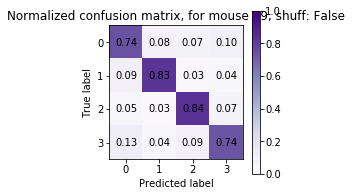

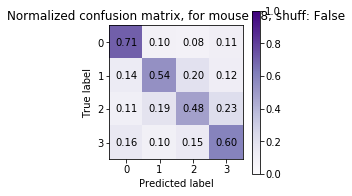

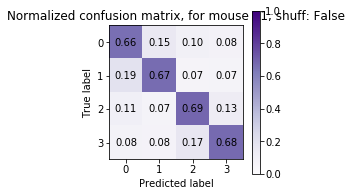

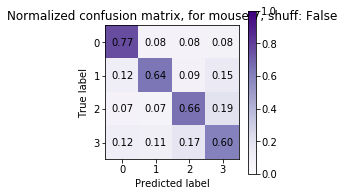

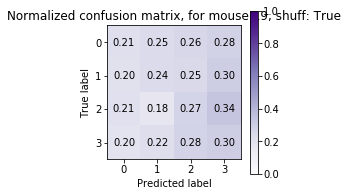

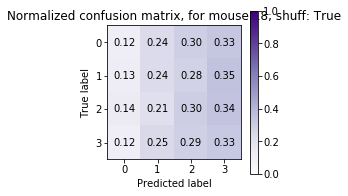

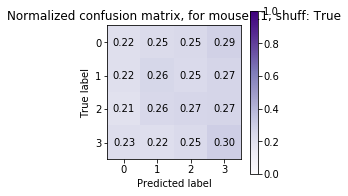

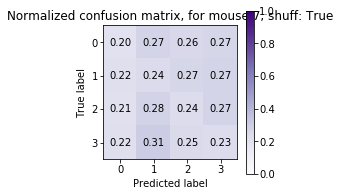

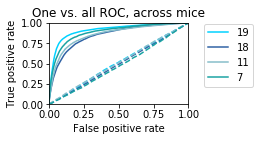

In [7]:
### Plot confusion matrices ROC curve for all sources vs. shuffled

### For plots in figs to karl (20190211) use 3-frame time window preceding behavior time point. 4way 75 pcs
# expts_for_ROC_plot = {
#     0: {'id': 19, 'expt_nums': np.arange(664, 668),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#     1: {'id': 19, 'expt_nums': np.arange(668, 672),'expt_type': 'neuron_set', 'info':10}, # shuffled
#     2: {'id': 18, 'expt_nums': np.arange(327, 331),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#     3: {'id': 18, 'expt_nums': np.arange(331, 335),'expt_type': 'neuron_set', 'info':10}, # shuffled
#     4: {'id': 11, 'expt_nums': np.arange(604, 608),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#     5: {'id': 11, 'expt_nums': np.arange(608, 612),'expt_type': 'neuron_set', 'info':10}, # shuffled
#     6: {'id': 7, 'expt_nums': np.arange(2139, 2143),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#     7: {'id': 7, 'expt_nums': np.arange(2135, 2139),'expt_type': 'neuron_set', 'info':10}, # shuffled
# }

### For updated plots (20190211) use 2-frame time window on and before behavior timepoint. 4way 75 pcs
# expts_for_ROC_plot = {
#     0: {'id': 19, 'expt_nums': np.arange(1021, 1025),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#     1: {'id': 19, 'expt_nums': np.arange(1025, 1029),'expt_type': 'neuron_set', 'info':10}, # shuffled
#     2: {'id': 18, 'expt_nums': np.arange(762, 766),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#     3: {'id': 18, 'expt_nums': np.arange(766, 770),'expt_type': 'neuron_set', 'info':10}, # shuffled
#     4: {'id': 11, 'expt_nums': np.arange(1010, 1014),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#     5: {'id': 11, 'expt_nums': np.arange(1014, 1018),'expt_type': 'neuron_set', 'info':10}, # shuffled
#     6: {'id': 7, 'expt_nums': np.arange(2564, 2568),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#     7: {'id': 7, 'expt_nums': np.arange(2568, 2572),'expt_type': 'neuron_set', 'info':10}, # shuffled
# }

# ### For updated plots (20190211) use 3-frame time window centered behavior time point. 4way 75 pcs
# expts_for_ROC_plot = {
#     0: {'id': 19, 'expt_nums': np.arange(949, 953),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#     1: {'id': 19, 'expt_nums': np.arange(953, 957),'expt_type': 'neuron_set', 'info':10}, # shuffled
#     2: {'id': 18, 'expt_nums': np.arange(690, 694),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#     3: {'id': 18, 'expt_nums': np.arange(694, 698),'expt_type': 'neuron_set', 'info':10}, # shuffled
#     4: {'id': 11, 'expt_nums': np.arange(938, 942),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#     5: {'id': 11, 'expt_nums': np.arange(942, 946),'expt_type': 'neuron_set', 'info':10}, # shuffled
#     6: {'id': 7, 'expt_nums': np.arange(2492, 2496),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#     7: {'id': 7, 'expt_nums': np.arange(2496, 2500),'expt_type': 'neuron_set', 'info':10}, # shuffled
# }

### The below are shuffled, 4way decoding. 3 bins centered on timepoint. 75 neurons. NON-BINARIZED. 20190814
# expts_for_ROC_plot = {
#         0: {'id': 19, 'expt_nums': np.arange(1165, 1169),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#         1: {'id': 19, 'expt_nums': np.arange(1169, 1173),'expt_type': 'neuron_set', 'info':10} # shuffled
#         2: {'id': 18, 'expt_nums': np.arange(906, 910),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#         3: {'id': 18, 'expt_nums': np.arange(910, 914),'expt_type': 'neuron_set', 'info':10}, # shuffled
#         4: {'id': 11, 'expt_nums': np.arange(1154, 1158),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#         5: {'id': 11, 'expt_nums': np.arange(1158, 1162),'expt_type': 'neuron_set', 'info':10}, # shuffled
#         6: {'id': 7, 'expt_nums': np.arange(2708, 2712),'expt_type': 'neuron_set', 'info':10}, # not shuffled
#         7: {'id': 7, 'expt_nums': np.arange(2712, 2716),'expt_type': 'neuron_set', 'info':10}, # shuffled

# }

# ### The below are shuffled, 4way decoding. 3 bins centered on timepoint. 75 neurons. z-scored. NON-BINARIZED. 20190821
# expts_for_ROC_plot = {
#     0: {'id': 19, 'expt_nums': np.arange(1237, 1241),'expt_type': 'neuron_set', 'info':10}, # not shuff
#     1: {'id': 19, 'expt_nums': np.arange(1241, 1245),'expt_type': 'neuron_set', 'info':10}, # shuff
#     2: {'id': 18, 'expt_nums': np.arange(981, 985),'expt_type': 'neuron_set', 'info':10}, # not shuff
#     3: {'id': 18, 'expt_nums': np.arange(985, 989),'expt_type': 'neuron_set', 'info':10}, # shuff
#     4: {'id': 11, 'expt_nums': np.arange(1226, 1230),'expt_type': 'neuron_set', 'info':10}, # not shuff
#     5: {'id': 11, 'expt_nums': np.arange(1230, 1234),'expt_type': 'neuron_set', 'info':10}, # shuff
#     6: {'id': 7, 'expt_nums': np.arange(2780, 2784),'expt_type': 'neuron_set', 'info':10}, # not shuff
#     7: {'id': 7, 'expt_nums': np.arange(2784, 2788),'expt_type': 'neuron_set', 'info':10}, # shuff
#     8: {'id': 35, 'expt_nums': np.arange(137, 141),'expt_type': 'neuron_set', 'info':10}, # not shuff
#     9: {'id': 35, 'expt_nums': np.arange(141, 145),'expt_type': 'neuron_set', 'info':10}, # shuff
# }

# ### The below are shuffled, 4way decoding. 1 bins centered on timepoint. 75 neurons. z-scored. NON-BINARIZED. 20190821
# expts_for_ROC_plot = {
#     0: {'id': 19, 'expt_nums': np.arange(1309, 1313),'expt_type': 'neuron_set', 'info':10}, # not shuff
#     1: {'id': 19, 'expt_nums': np.arange(1313, 1317),'expt_type': 'neuron_set', 'info':10}, # shuff
#     2: {'id': 18, 'expt_nums': np.arange(1053, 1057),'expt_type': 'neuron_set', 'info':10}, # not shuff
#     3: {'id': 18, 'expt_nums': np.arange(1057, 1061),'expt_type': 'neuron_set', 'info':10}, # shuff
#     4: {'id': 11, 'expt_nums': np.arange(1298, 1302),'expt_type': 'neuron_set', 'info':10}, # not shuff
#     5: {'id': 11, 'expt_nums': np.arange(1302, 1306),'expt_type': 'neuron_set', 'info':10}, # shuff
#     6: {'id': 7, 'expt_nums': np.arange(2852, 2856),'expt_type': 'neuron_set', 'info':10}, # not shuff
#     7: {'id': 7, 'expt_nums': np.arange(2856, 2860),'expt_type': 'neuron_set', 'info':10}, # shuff
# }

### The below are CIRCULARLY shuffled, 4way decoding. 1 bins centered on timepoint. 75 neurons. z-scored. NON-BINARIZED. 20190821
expts_for_ROC_plot = {
    0: {'id': 19, 'expt_nums': np.arange(1309, 1313),'expt_type': 'neuron_set', 'info':10}, # not shuff
    1: {'id': 19, 'expt_nums': np.arange(1317, 1321),'expt_type': 'neuron_set', 'info':10}, # shuff
    2: {'id': 18, 'expt_nums': np.arange(1053, 1057),'expt_type': 'neuron_set', 'info':10}, # not shuff
    3: {'id': 18, 'expt_nums': np.arange(1061, 1065),'expt_type': 'neuron_set', 'info':10}, # shuff
    4: {'id': 11, 'expt_nums': np.arange(1298, 1302),'expt_type': 'neuron_set', 'info':10}, # not shuff
    5: {'id': 11, 'expt_nums': np.arange(1306, 1310),'expt_type': 'neuron_set', 'info':10}, # shuff
    6: {'id': 7, 'expt_nums': np.arange(2852, 2856),'expt_type': 'neuron_set', 'info':10}, # not shuff
    7: {'id': 7, 'expt_nums': np.arange(2860, 2864),'expt_type': 'neuron_set', 'info':10}, # shuff
}



expt_sets = np.array([[0, 1], [2, 3], [4, 5], [6, 7]])
expt_sets_notshuff = expt_sets[:, 0]
expt_sets_shuff = expt_sets[:, 1]

(all_mean_fpr,
 all_mean_tpr,
 all_labels) = get_ROC_curves(expts_for_ROC_plot, 
                              expt_sets_notshuff, 
                              data_dir,
                              fig_save_dir,
                              do_plot_confusion_matrices=True,
                              do_plot_individual_roc_curves=False,
                              is_shuff=False)

(all_mean_fpr_shuff,
 all_mean_tpr_shuff, _) = get_ROC_curves(expts_for_ROC_plot,
                                         expt_sets_shuff, 
                                         data_dir,
                                         fig_save_dir,
                                         do_plot_confusion_matrices=True,
                                         do_plot_individual_roc_curves=False,
                                         is_shuff=True)

            
plt.figure()
for i in range(len(all_mean_fpr_shuff)):
    plt.plot(all_mean_fpr[i], all_mean_tpr[i], color=mouse_colors[i], label=all_labels[i])
    plt.plot(all_mean_fpr_shuff[i], all_mean_tpr_shuff[i], color=mouse_colors[i], linestyle='--', label=None)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.gca().legend(bbox_to_anchor=(1.5, 1.05))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('One vs. all ROC, across mice')
plt.gcf().set_size_inches(w=2.5, h=1.5) # Control size of figure in inches
plt.savefig(fig_save_dir + 'roc_curves_' + 'across_mice' +'.pdf',
        transparent=True, rasterized=True, dpi=600) 

In [8]:
### TODO? Make a class that does all of this????

1240
1401
(1/3) Loading trace data.
(2/3) Loading behavior data.
While loading bpod, enforcing that ntrials is:211
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
LED trials: 212
Processing traces.
[-34.99899927 423.99899927]
[297.73913811 301.26086189]
(1/3) Loading trace data.
(2/3) Loading behavior data.
While loading bpod, enforcing that ntrials is:194
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
LED trials: 195
Processing traces.
[ -0.98693836 480.98693836]
[346.31439921 364.68560079]
(1/3) Loading trace data.
(2/3) Loading behavior data.
While loading bpod, enforcing that ntrials is:200
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
LED trials: 201
Processing traces.
[-33.89918334 518.89918334]
[331.76352531 366.23647469]
(1/3) Loading trace data.
(2/3) Loading behavior data.
While loading bpod, enf

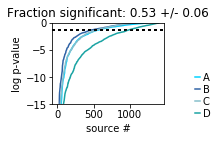

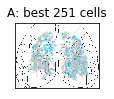

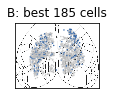

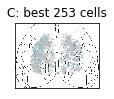

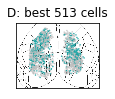

In [9]:
### Plot anova pvalue for each neuron to find the significantly discriminative ones. 

do_plot_ordering = True
do_load_CT = True ### Must set to True the first time you run this cell, but then can set to False
do_plot_significant = True
do_plot_significance = False

# expt_ids = [29, 24, 25, 28] ### Decoding with all sources
# expt_ids = [213, 214, 215, 216] ### Decoding with all sources
# expt_ids = [119, 120, 121, 122] ### Decoding with all sources
# expt_ids = [400, 401, 402, 403] ### Decoding with all sources
# expt_ids = [513, 514, 515, 516] ### 3-frames centered on behav timepoint. Decoding with all sources
# expt_ids = [813, 814, 815, 816] ### 3-frames centered on behav timepoint. Non-binarized score. Decoding with all sources
expt_ids = [913, 914, 915, 916] ### 1-frames centered on behav timepoint. Non-binarized score. Decoding with all sources

mc = mouse_colors
# mouse_colors_dict = {7: mc[0], 11: mc[1], 18:mc[2], 19:mc[3]}
mouse_colors_dict = {7:['#00d2ff', 'A'], 11:['#3063A5', 'B'], 18:['#86becb', 'C'], 19:['#1aa3a3', 'D']}

if do_plot_ordering:
    (all_ordering,
     labels) = plot_discrimination_capacity_ordering(concluded_expts, 
                                                     expt_ids, 
                                                     data_dir, 
                                                     mouse_colors_dict, 
                                                     fig_save_dir)
if do_load_CT:
    allCT = []
    for ind, expt_id in enumerate(expt_ids):
        load_dataset_id = concluded_expts[expt_id]['id']        
        dataset = params.DATASETS[load_dataset_id]
        dataset['data_root'] = data_dir
        dataset['fig_save_dir'] = base_dir + '/cosmos/trace_analysis/'
        dataset['behavior_dir'] = bpod_dir
        CT = CosmosTraces(dataset, behavior_plots=False)
        allCT.append(CT)
        
if do_plot_significant:
    plot_significant_discrimination_capacity_sources(concluded_expts,
                                                     expt_ids,
                                                     all_ordering,
                                                     allCT,
                                                     mouse_colors_dict,
                                                     fig_save_dir)        
    
if do_plot_significance:
    plot_discrimination_capacity_of_sources(concluded_expts,
                                                 expt_ids,
                                                 all_ordering,
                                                 allCT,
                                                 mouse_colors_dict,
                                                 fig_save_dir)    

In [37]:
np.min(np.log10(np.sort(all_ordering[0])))

-67.12382280570465

In [38]:
vals = -np.log10(np.sort(all_ordering[0]))
vals = vals/np.max(vals)

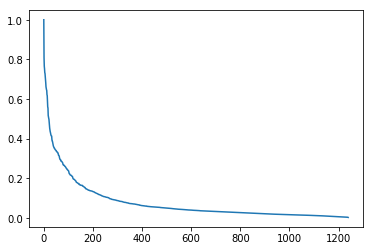

In [39]:
plt.plot(vals)

In [30]:
fig_save_dir

'/home/izkula/Dropbox//cosmos/fig_plots/fig6/nonbinarized'

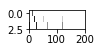

In [31]:
### Plot some example population activity for diagram in figure. 
plt.figure(figsize=(6, 2))
plt.imshow(CT.St[100:300, 100:103, 1].T, aspect='auto', cmap='gray_r')
plt.gcf().set_size_inches(w=1, h=0.35)
plt.savefig(os.path.join(fig_save_dir, 'example_population-activity.pdf'))

## Plot example lick traces for all_neurons, and for a smaller number of neurons. 

In [15]:
### Now load a specific dataset and experiment for plotting example decodings and performance. 
# Plot example decoded lick traces.

examples = [
        ### Some other potential datasets to use.
#             {'id': 7, 'expt_num':1801, 'trial_inds':[5, 10]},
#             {'id': 19, 'expt_num':578, 'trial_inds':[5, 10]}, ### This is what you used in the figures 20190211
#             {'id': 19, 'expt_num':1021, 'trial_inds':[4, 11]}, ### Now with three centered timepoints 20190211 1021-1025
#             {'id': 19, 'expt_num':1237, 'trial_inds':[4, 11]}, ### Now with zscored, nonbinarized, three centered timepoints 20190211 1021-1025
            {'id': 19, 'expt_num':1309, 'trial_inds':[4, 11]}, ### Now with zscored, nonbinarized, three centered timepoints 20190211 1021-1025

]

In [16]:
# Load individual dataset. 
load_dataset_id = examples[0]['id']
decoding_load_dir = os.path.join(data_dir, 'decoding_results', str(load_dataset_id))
dataset = params.DATASETS[load_dataset_id]
CT_load = load_cosmos_traces(dataset, data_dir, base_dir, bpod_dir, do_behavior_plots=False)

(1/3) Loading trace data.
(2/3) Loading behavior data.
While loading bpod, enforcing that ntrials is:200
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
LED trials: 201
Processing traces.
[ 22.0399507 515.9600493]
[393.84706348 347.15293652]


Data split into train, test, validate sets. 
Fractions: Train 0.495, Test 0.257 Valid 0.248
Z-scoring X!!
Max X 40.20691658816435
X_train: (28700, 1, 1401) X_test: (14924, 1, 1401)
EVR: 0.1149026842411556


/home/izkula/anaconda/envs/cosmos3/lib/python3.5/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


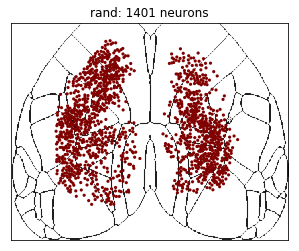

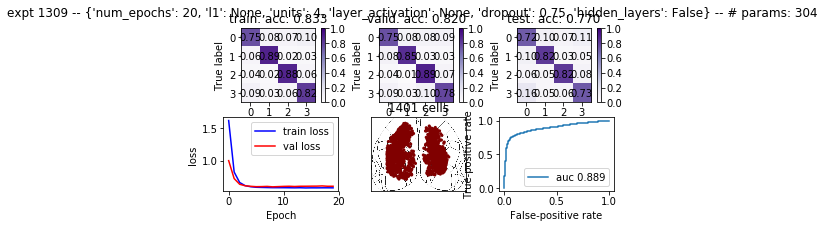

In [17]:
# Load individual decoding experiment. 
expt_num= examples[0]['expt_num'] #1021 #578# 511 #117
(ds, decode_summary) = load_individual_decoding_experiment(CT_load, decoding_load_dir, 
                                                       expt_num,load_dataset_id,
                                                       do_plot=True, fig_save_dir=fig_save_dir)

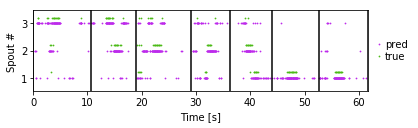

In [18]:
# Now, actually plot example decoded licks from this decoding experiment. 
start_trial = examples[0]['trial_inds'][0]
end_trial = examples[0]['trial_inds'][1]

plot_example_decoded_licks(CT_load, ds, decode_summary, 
                           start_trial, end_trial, 
                           load_dataset_id, expt_num, fig_save_dir)

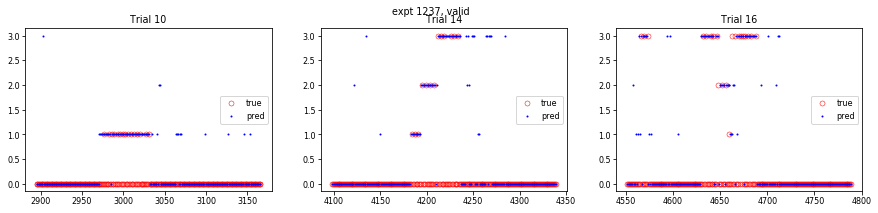

In [36]:
### Plot individual trials.
# trials = [10, 15, 20]
# trials = [10, 14, 25]
trials = [10, 14, 16]


plot_decoded_trials(trials, ds, decode_summary, expt_num, subset='valid')


In [17]:
raise('Done')

TypeError: exceptions must derive from BaseException

> <ipython-input-17-733a9420e381>(1)<module>()
----> 1 raise('Done')

ipdb> quit()


### BELOW: SANDBOX.  Trying smoothed lick rate decoding.  

In [206]:
pred_licks = decode_summary['licks_pred'][data_subset]
true_licks = decode_summary['licks_true'][data_subset]

h = scipy.spatial.distance.hamming(pred_licks, true_licks, w=None)

In [208]:
1 - h

0.6774344883050734

In [205]:
np.unique(pred_licks)

array([0, 1, 2, 3])

In [85]:
### Define lick rate as the inverse of the lick interval?
def get_lick_rate(lick_frames, dt):
    """
    Compute lick rate as the inverse of the inter-lick interval.
    Return an array with same dimensions as lick_frames.
    
    :param lick_frames: boolean array indicating whether a lick happend at each frame.
    :param dt: time of one frame, in seconds. 
    """
    
    lick_rates = np.zeros(len(lick_frames))
    lick_inds = np.where(lick_frames)[0]
    for i in range(len(lick_inds)-1):
        ind = lick_inds[i]
        next_ind = lick_inds[i+1]
        lick_rates[ind:next_ind] = 1.0/(dt*(next_ind-ind))
    return lick_rates
    
    

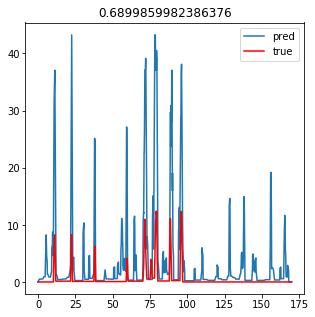

In [92]:
which_spout = 2
spout1_pred = decode_summary['licks_pred'][data_subset][idx] == which_spout
spout1_true = decode_summary['licks_true'][data_subset][idx] == which_spout

spout1_true = get_lick_rate(spout1_true, dt)
spout1_pred = get_lick_rate(spout1_pred, dt)

window_size = 20
spout1_pred = utils.moving_avg(spout1_pred.astype(float),window=window_size)/(window_size*dt)
spout1_true = utils.moving_avg(spout1_true.astype(float), window=window_size)/(window_size*dt)

plt.figure(figsize=(5, 5))
# plt.plot(t, spout1_pred/np.max(spout1_pred), label='pred')
# plt.plot(t, spout1_true/np.max(spout1_true), 'r', label='true')
plt.plot(t, spout1_pred, label='pred')
plt.plot(t, spout1_true, 'r', label='true')
plt.title(rsquared(spout1_pred, spout1_true))
plt.legend()

In [ ]:
### TODO: You could try to independently predict each spout. Is that legal? 

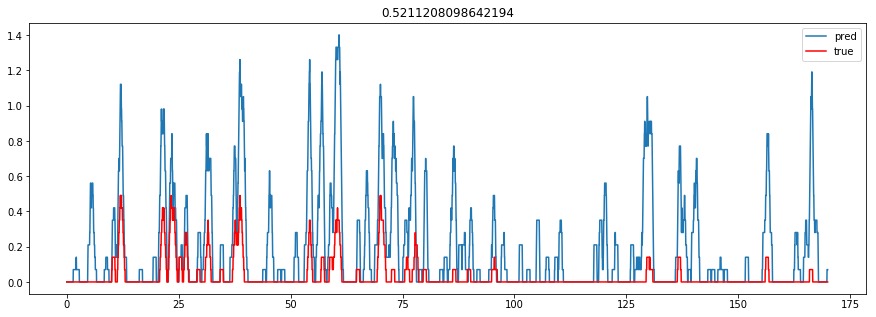

In [76]:
### Now plot smoothed lick trace for one spout at a time. 
which_spout = 3
spout1_pred = decode_summary['licks_pred'][data_subset][idx] == which_spout
spout1_true = decode_summary['licks_true'][data_subset][idx] == which_spout

# spout1_pred = gaussian_filter1d(spout1_pred.astype(float), 5, axis=0, mode='constant')
# spout1_true = gaussian_filter1d(spout1_true.astype(float), 5, axis=0, mode='constant')
window_size = 20
spout1_pred = utils.moving_avg(spout1_pred.astype(float),window=window_size)/(window_size*dt)
spout1_true = utils.moving_avg(spout1_true.astype(float), window=window_size)/(window_size*dt)


plt.figure(figsize=(15, 5))
# plt.plot(t, spout1_pred/np.max(spout1_pred), label='pred')
# plt.plot(t, spout1_true/np.max(spout1_true), 'r', label='true')
plt.plot(t, spout1_pred, label='pred')
plt.plot(t, spout1_true, 'r', label='true')
plt.title(rsquared(spout1_pred, spout1_true))
plt.legend()

In [ ]:
# Plot region comparison (across mice?).

In [260]:
# #### TESTING. THIS CELL WAS MADE DURING DEBUGGING. TODO: FINISH THIS!
# # expt_ids = [213]
# expt_ids = [400, 401, 402, 403]

# max_len = 0

# for ind, expt_id in enumerate(expt_ids):
#     expt_group = concluded_expts[expt_id]
#     decoding_load_dir = os.path.join(data_dir, 'decoding_results', str(expt_group['id']))
#     expt_num = expt_group['expt_nums'][0]
#     expt_file = os.path.join(decoding_load_dir,
#                              'expt_{:06}'.format(expt_num))

#     with open(expt_file + '_opts', "rb") as handle:
#         opts = pickle.load(handle)
#     ordering = np.sort(opts['expt_param']['minpvals'])
    
#     if np.max(len(ordering)) > max_len:
#         max_len = np.max(len(ordering))
#         print(max_len)
#     plt.plot(np.log10(ordering, color=mouse_colors[ind])
#     plt.ylim([-15, 0])
    
# plt.xticks([0, 500, 1000])
# plt.ylabel('log p-value')
# plt.xlabel('source #')
# legend = plt.legend(frameon=False, 
#                     bbox_to_anchor=(1.5, 0.5), handlelength=0.5, 
#                     handletextpad=0.3, labelspacing=0.2)
# plt.axhline(np.log10(0.05/max_len), color=(0,0,0,1), dashes=[2, 2])


SyntaxError: invalid syntax (<ipython-input-260-35bd95bbe8cf>, line 16)

In [22]:
### TODO: Figure out which expt_num had the best performance...based on accs_list
### This currently depends on previous cells ... not very modular. 
### This code is also not necessary for subsequent cells.
do_determine_best_expt_in_group = False
if do_determine_best_expt_in_group:
    expt_nums_organized  = all_expt_nums_organized[expt_ids.index(expt_id)]
    accs_list = all_accs_list[expt_ids.index(expt_id)]

    best_expts = dict() ## For each experiment group condition, which experiment yielded the highest accuracy.
    for i in range(len(accs_list)):
        best_expt = expt_nums_organized[i][np.argmax(accs_list[i])]
        expt_acc = accs_list[i][np.argmax(accs_list[i])]
        best_expts[accs_names[i]] = [best_expt, expt_acc]
    best_expts